In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2025-01-03 10:47:07.866551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 10:47:07.882905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 10:47:07.888007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1735897629.168870  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897629.205385  721603 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [1]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    with SequenceDataset(train_filename, fmt="fasta") as data:
        batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(
            EmbeddingBatchGenerator.generic_compute_embedding_func(data, config["scoring_model_config"]))
        config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

I0000 00:00:1735897706.956734  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897706.956995  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897706.957164  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897706.957368  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1735897709.334843  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897709.335098  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897709.335265  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897709.335468  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 23s - 498ms/step - loss: 109.1368 - loglik: -9.2418e+01 - prior: -1.6718e+01 - aux_loss: 0.0000e+00
Epoch 2/10
46/46 - 5s - 99ms/step - loss: 76.0829 - loglik: -7.0336e+01 - prior: -5.7466e+00 - aux_loss: 0.0000e+00
Epoch 3/10
46/46 - 5s - 98ms/step - loss: 73.1678 - loglik: -6.8700e+01 - prior: -4.4675e+00 - aux_loss: 0.0000e+00
Epoch 4/10
46/46 - 4s - 97ms/step - loss: 72.5129 - loglik: -6.8508e+01 - prior: -4.0048e+00 - aux_loss: 0.0000e+00
Epoch 5/10
46/46 - 5s - 99ms/step - loss: 72.2013 - loglik: -6.8373e+01 - prior: -3.8284e+00 - aux_loss: 0.0000e+00
Epoch 6/10
46/46 - 5s - 98ms/step - loss: 72.1139 - loglik: -6.8361e+01 - prior: -3.7530e+00 - aux_loss: 0.0000e+00
Epoch 7/10
46/46 - 4s - 97ms/step - loss: 71.9045 - loglik: -6.8202e+01 - prior: -3.7030e+00 - aux_loss: 0.0000e+00
Epoch 8/10
46/46 - 5s - 99ms/step - loss: 71.8338 - loglik: -6.8154e+01 - prior: -3.6799e+00 - aux_loss: 0.0000e+00
Epoch 9/10
46/46 - 5s - 98ms/step - loss: 71.7929 - loglik: -6.8147e+01 - prior:

I0000 00:00:1735897775.634176  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897775.634433  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897775.634594  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897775.634796  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 3), (14, 2), (15, 1)]
discards model 0: []
expansions model 1: [(12, 2), (13, 3), (16, 1), (17, 2)]
discards model 1: []
expansions model 2: [(12, 2), (13, 3), (16, 1), (17, 1)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (14, 1), (17, 2), (19, 2)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [34, 34, 33, 35] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
1 sequences are longer than 65 and will be cropped for training.
To disable cropping, use --crop disable. To change the cropping limit to X, use --crop X.
Using 1 GPUs.


I0000 00:00:1735897781.385589  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897781.385859  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897781.386020  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897781.386229  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1735897783.355108  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897783.355366  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897783.355526  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897783.355729  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 22s - 486ms/step - loss: 81.2412 - loglik: -6.5484e+01 - prior: -1.5757e+01 - aux_loss: 0.0000e+00
Epoch 2/20
46/46 - 5s - 100ms/step - loss: 69.8054 - loglik: -6.4122e+01 - prior: -5.6835e+00 - aux_loss: 0.0000e+00
Epoch 3/20
46/46 - 5s - 99ms/step - loss: 68.7630 - loglik: -6.4431e+01 - prior: -4.3321e+00 - aux_loss: 0.0000e+00
Epoch 4/20
46/46 - 5s - 100ms/step - loss: 68.0900 - loglik: -6.4208e+01 - prior: -3.8821e+00 - aux_loss: 0.0000e+00
Epoch 5/20
46/46 - 5s - 100ms/step - loss: 67.9478 - loglik: -6.4254e+01 - prior: -3.6939e+00 - aux_loss: 0.0000e+00
Epoch 6/20
46/46 - 5s - 100ms/step - loss: 67.9480 - loglik: -6.4356e+01 - prior: -3.5923e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.
Time for alignment: 166.5424
Likelihoods:  ['-61.4438', '-61.3572', '-61.3824', '-61.4452']
Mean likelihood:  -61.40716686204616
Selection criterion: AIC
Best model:  1 (0-based)


I0000 00:00:1735897833.326366  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897833.326641  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897833.326805  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897833.327009  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 1 insertion slices with famsa.
time for generating output: 4.0532
Wrote file test/data/interactive.alignment.fasta
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step
>l=-56.86_t=0.01
........$CD.......P........N............P........CYN.HG..T..C-...SL.....................-....RAT........G..........Y.TCSCL....PR......Y....T...GEH$.......................
>l=-58.10_t=0.01
........$CD.......S........Q............P........CRN.-G..T..CS...LN.....................-....TNT........D..........Y.TCACF....PG......Y....T...GRY$.......................
>l=-51.86_t=0.01
........$CD.......S........D............P........CLN.GG..T..C-...TL.....................R....SLD........S..........Y.SCACA....PG......Y....T...GQH$.......................
>l=-65.45_t=0.01
........$CD.......H........V............T........CLN.GG..T..C-...QL.....................K....TLE........D..........Y.TCACA....NG......Y....T...GER$.......................
>l=-65.98_t=0.01
........$CD.......H........V............T........CLN.GG..T..C-...QL

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1735897842.408686  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897842.408924  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735897842.409085  721603 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative 

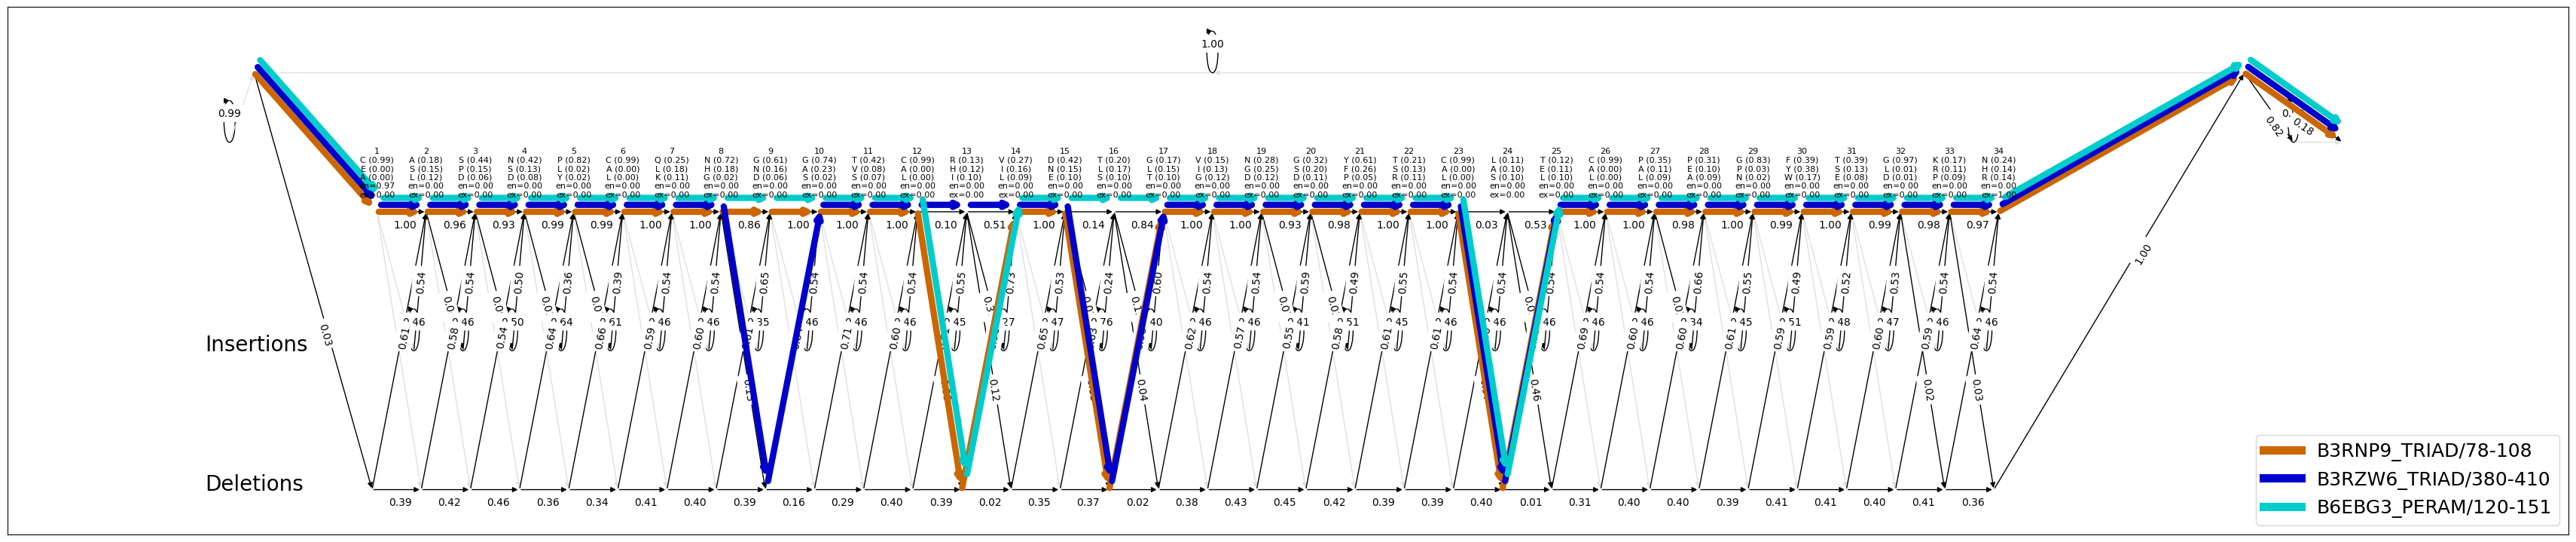

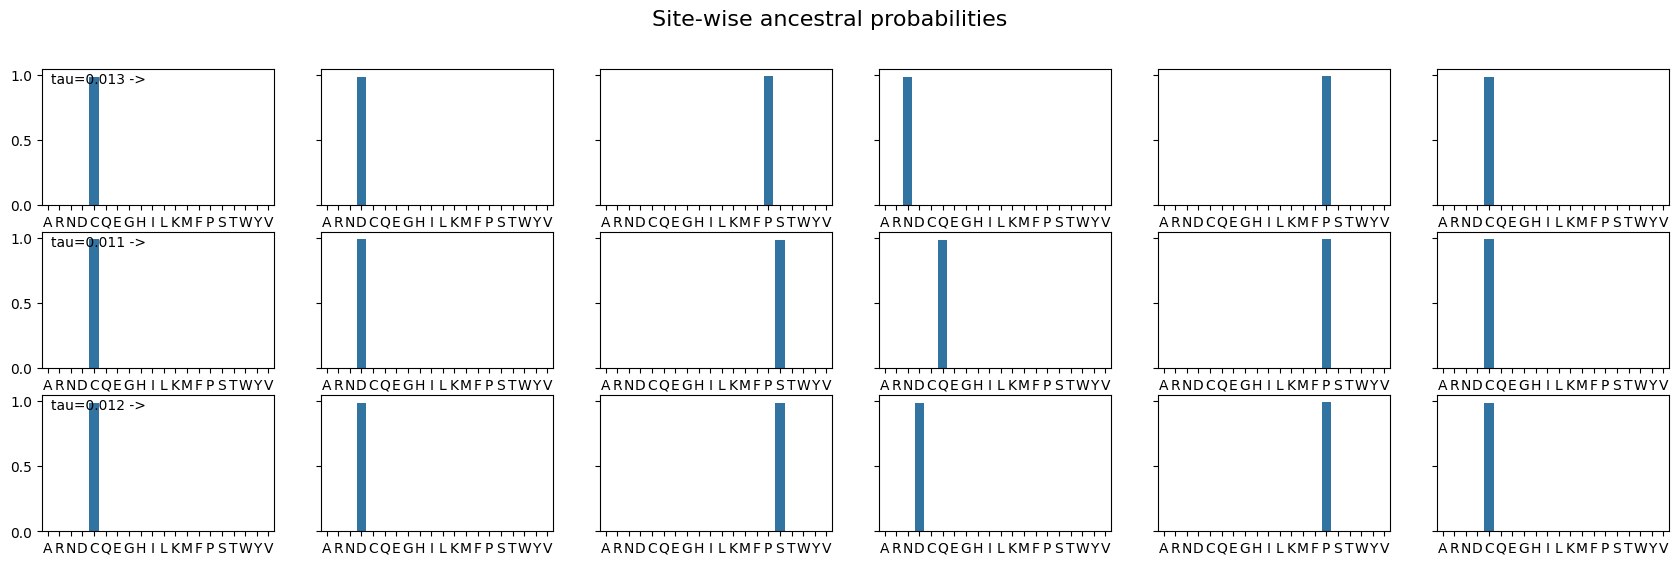

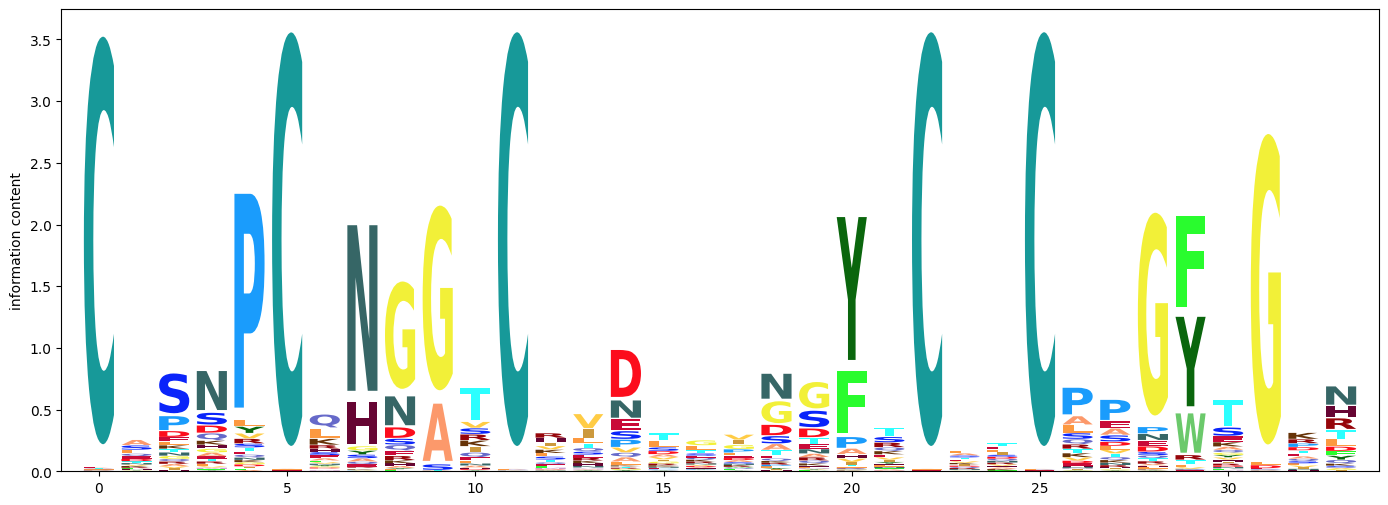

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [2]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [3]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    79.5 [100.0]   [ 5182]
